In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

# =====================================================
# 0) Config
# =====================================================
RESULTS_CSV = "all_model_param_results.csv"   # <- your new file from the grid runs
OUTDIR_NAME = "cross_check_outputs"           # same as before
# Choose the primary model-selection metric for "best per dataset/model"
PRIMARY_METRIC = "CV_F1_mean"                 # good default; options: CV_Accuracy_mean, Holdout_F1_macro, etc.
TIEBREAKER_METRIC = "CV_Accuracy_mean"        # used only when PRIMARY_METRIC ties or is missing

# =====================================================
# 1) Read results
# =====================================================
df = pd.read_csv(RESULTS_CSV)
print("Loaded shape:", df.shape)
print(df.head(3))

# Ensure required columns exist (robustness to partial logs)
required_cols = ["Dataset", "Model", "Params"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# Helpful: Parse JSON params into normalized columns (optional but nice)
def try_parse_json(s):
    try:
        return json.loads(s)
    except Exception:
        return {}

params_expanded = df["Params"].apply(try_parse_json).apply(pd.Series)
# Prefix param columns to avoid collisions
if params_expanded.shape[1] > 0:
    params_expanded = params_expanded.add_prefix("param__")
    df = pd.concat([df.drop(columns=["Params"]), params_expanded], axis=1)

# Some metric columns might be missing depending on your run; create if absent
for col in ["Accuracy","F1_macro","Train_time_s","Infer_time_s",
            "CV_Accuracy_mean","CV_Accuracy_std","CV_F1_mean","CV_F1_std",
            "Holdout_Accuracy","Holdout_F1_macro","Holdout_Train_time_s","Holdout_Infer_time_s"]:
    if col not in df.columns:
        df[col] = np.nan

# =====================================================
# 2) Build a "best-per-dataset-per-model" table
#    - Select the single best hyperparam row per (Dataset, Model)
# =====================================================
def pick_best(group, primary=PRIMARY_METRIC, tiebreak=TIEBREAKER_METRIC):
    g = group.copy()
    # sort: primary desc, then tiebreak desc, then fastest score time if available
    sort_cols = []
    ascending = []
    if primary in g.columns:
        sort_cols.append(primary); ascending.append(False)
    if tiebreak in g.columns:
        sort_cols.append(tiebreak); ascending.append(False)
    # (Optional) prefer faster models when metrics tie closely
    for speed_col in ["Score_time_mean_s", "Infer_time_s"]:
        if speed_col in g.columns:
            sort_cols.append(speed_col); ascending.append(True)
    if not sort_cols:
        # fallback: keep first row
        return g.iloc[[0]]
    return g.sort_values(sort_cols, ascending=ascending, na_position="last").iloc[[0]]

best_rows = (
    df.groupby(["Dataset","Model"], group_keys=False)
      .apply(pick_best)
      .reset_index(drop=True)
)

print("Best rows shape:", best_rows.shape)
print(best_rows.head(3))

# =====================================================
# 3) Summaries across datasets, using ONLY the best rows
# =====================================================
summary_cols = [
    "Accuracy", "F1_macro", "Train_time_s", "Infer_time_s",
    "CV_Accuracy_mean", "CV_Accuracy_std", "CV_F1_mean", "CV_F1_std",
    "Holdout_Accuracy", "Holdout_F1_macro", "Holdout_Train_time_s", "Holdout_Infer_time_s"
]

best_summary = (
    best_rows.groupby("Model", as_index=False)[summary_cols]
             .mean(numeric_only=True)
             .sort_values(PRIMARY_METRIC if PRIMARY_METRIC in summary_cols else "CV_F1_mean",
                          ascending=False)
)

# Count wins per dataset (who tops the chosen metric)
def count_wins(metric, table):
    # winners within each dataset by metric
    winners = table.loc[table.groupby("Dataset")[metric].idxmax()]
    vc = winners["Model"].value_counts()
    vc.name = f"Wins_{metric}"
    return vc

wins_primary = count_wins(PRIMARY_METRIC, best_rows) if PRIMARY_METRIC in best_rows.columns else pd.Series(dtype=int)
wins_f1 = count_wins("CV_F1_mean", best_rows) if "CV_F1_mean" in best_rows.columns else pd.Series(dtype=int)
wins_acc = count_wins("CV_Accuracy_mean", best_rows) if "CV_Accuracy_mean" in best_rows.columns else pd.Series(dtype=int)

best_summary = (
    best_summary
    .merge(wins_primary, left_on="Model", right_index=True, how="left")
    .merge(wins_f1, left_on="Model", right_index=True, how="left")
    .merge(wins_acc, left_on="Model", right_index=True, how="left")
    .rename(columns={
        f"Wins_{PRIMARY_METRIC}": f"Wins_primary({PRIMARY_METRIC})",
        "Wins_CV_F1_mean": "Wins_CV_F1_mean",
        "Wins_CV_Accuracy_mean": "Wins_CV_Accuracy_mean"
    })
    .fillna(0)
)

# =====================================================
# 4) Per-dataset pivot tables (using the best rows)
# =====================================================
acc_pivot_best = best_rows.pivot(index="Dataset", columns="Model", values="Accuracy")
f1_pivot_best  = best_rows.pivot(index="Dataset", columns="Model", values="F1_macro")
cv_acc_pivot_best = best_rows.pivot(index="Dataset", columns="Model", values="CV_Accuracy_mean")
cv_f1_pivot_best  = best_rows.pivot(index="Dataset", columns="Model", values="CV_F1_mean")

# =====================================================
# 5) (Optional) Stability view: average over ALL param settings
#     Shows how models behave across their grid, not just the single best pick
# =====================================================
avg_over_all = (
    df.groupby(["Dataset","Model"], as_index=False)[summary_cols]
      .mean(numeric_only=True)
)

acc_pivot_avg = avg_over_all.pivot(index="Dataset", columns="Model", values="Accuracy")
f1_pivot_avg  = avg_over_all.pivot(index="Dataset", columns="Model", values="F1_macro")
cv_acc_pivot_avg = avg_over_all.pivot(index="Dataset", columns="Model", values="CV_Accuracy_mean")
cv_f1_pivot_avg  = avg_over_all.pivot(index="Dataset", columns="Model", values="CV_F1_mean")

# =====================================================
# 6) Round for readability
# =====================================================
def round_inplace(dfs, ndigits=3):
    for d in dfs:
        if isinstance(d, pd.DataFrame):
            for c in d.select_dtypes(include=[np.number]).columns:
                d[c] = d[c].round(ndigits)

round_inplace([
    best_summary, acc_pivot_best, f1_pivot_best, cv_acc_pivot_best, cv_f1_pivot_best,
    acc_pivot_avg, f1_pivot_avg, cv_acc_pivot_avg, cv_f1_pivot_avg
], ndigits=3)

# =====================================================
# 7) Save outputs (CSV + LaTeX)
# =====================================================
outdir = Path(OUTDIR_NAME)
outdir.mkdir(exist_ok=True)

best_summary.to_csv(outdir / "cross_dataset_summary__best_per_model.csv", index=False)
acc_pivot_best.to_csv(outdir / "per_dataset_accuracy__best.csv")
f1_pivot_best.to_csv(outdir / "per_dataset_f1__best.csv")
cv_acc_pivot_best.to_csv(outdir / "per_dataset_cv_accuracy__best.csv")
cv_f1_pivot_best.to_csv(outdir / "per_dataset_cv_f1__best.csv")

# Also export the "avg-over-all-params" pivots
acc_pivot_avg.to_csv(outdir / "per_dataset_accuracy__avg_all_params.csv")
f1_pivot_avg.to_csv(outdir / "per_dataset_f1__avg_all_params.csv")
cv_acc_pivot_avg.to_csv(outdir / "per_dataset_cv_accuracy__avg_all_params.csv")
cv_f1_pivot_avg.to_csv(outdir / "per_dataset_cv_f1__avg_all_params.csv")

def to_latex(df_, caption, label, index=True):
    return df_.to_latex(escape=True, index=index, caption=caption, label=label, float_format="%.3f")

latex_best_summary = to_latex(
    best_summary.set_index("Model"),
    f"Average performance across datasets using the best hyperparameters per model per dataset (primary metric: {PRIMARY_METRIC}).",
    "tab:cross_dataset_summary_best"
)

latex_acc_best = to_latex(acc_pivot_best,
    "Per-dataset Accuracy by model (best hyperparameters).",
    "tab:per_dataset_accuracy_best"
)
latex_f1_best = to_latex(f1_pivot_best,
    "Per-dataset F1-macro by model (best hyperparameters).",
    "tab:per_dataset_f1_best"
)
latex_cv_acc_best = to_latex(cv_acc_pivot_best,
    "Per-dataset CV Accuracy mean by model (best hyperparameters).",
    "tab:per_dataset_cv_accuracy_best"
)
latex_cv_f1_best = to_latex(cv_f1_pivot_best,
    "Per-dataset CV F1 mean by model (best hyperparameters).",
    "tab:per_dataset_cv_f1_best"
)

# Optional: LaTeX for the stability (avg over all param settings) pivots
latex_cv_f1_avg = to_latex(cv_f1_pivot_avg,
    "Per-dataset CV F1 mean by model (average over all hyperparameter settings).",
    "tab:per_dataset_cv_f1_avg"
)

with open(outdir / "tables_best_and_avg.tex", "w", encoding="utf-8") as f:
    f.write("% Best-per-model-per-dataset summary\n")
    f.write(latex_best_summary + "\n\n")
    f.write("% Best hyperparameters pivots\n")
    f.write(latex_acc_best + "\n\n")
    f.write(latex_f1_best + "\n\n")
    f.write(latex_cv_acc_best + "\n\n")
    f.write(latex_cv_f1_best + "\n\n")
    f.write("% Average-over-all-params CV F1 (stability view)\n")
    f.write(latex_cv_f1_avg + "\n\n")

print("✅ Exports written to:", outdir.resolve())

# =====================================================
# 8) (Optional) In-notebook display
# =====================================================
try:
    from IPython.display import display, Markdown
    display(Markdown("### Best-per-model-per-dataset: Summary"))
    display(best_summary)
    display(Markdown("### Best-per-model-per-dataset: CV F1 Pivot"))
    display(cv_f1_pivot_best)
    display(Markdown("### Average over all param settings: CV F1 Pivot"))
    display(cv_f1_pivot_avg)
except Exception:
    pass

Loaded shape: (632, 16)
    Dataset    Model                                             Params  \
0  dataset1  SVM_rbf  {"svc__C": 0.1, "svc__class_weight": null, "sv...   
1  dataset1  SVM_rbf  {"svc__C": 0.1, "svc__class_weight": null, "sv...   
2  dataset1  SVM_rbf  {"svc__C": 0.1, "svc__class_weight": null, "sv...   

   CV_Accuracy_mean  CV_Accuracy_std  CV_F1_mean  CV_F1_std  Fit_time_mean_s  \
0          0.624989         0.010051    0.560024   0.010429         0.010451   
1          0.624989         0.010051    0.560024   0.010429         0.010206   
2          0.476564         0.031373    0.367235   0.043346         0.011156   

   Fit_time_std_s  Score_time_mean_s  Score_time_std_s  Holdout_Accuracy  \
0        0.000382           0.004913          0.000152          0.655844   
1        0.000104           0.004872          0.000061          0.655844   
2        0.000182           0.004859          0.000153          0.441558   

   Holdout_F1_macro  Holdout_Train_time_s  Holdou

/var/folders/3m/lmf4h7mj7nz6y587tc98f7sm0000gn/T/ipykernel_53406/2524287495.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["Dataset","Model"], group_keys=False)


### Best-per-model-per-dataset: Summary

,Model,Accuracy,F1_macro,Train_time_s,Infer_time_s,CV_Accuracy_mean,CV_Accuracy_std,CV_F1_mean,CV_F1_std,Holdout_Accuracy,Holdout_F1_macro,Holdout_Train_time_s,Holdout_Infer_time_s,Wins_CV_F1_mean_x,Wins_CV_F1_mean_y,Wins_CV_Accuracy_mean
1,RandomForest,0.0,0.0,0.0,0.0,0.923,0.006,0.901,0.007,0.921,0.899,7.894,0.041,4.0,4.0,3.0
2,SVM_rbf,0.0,0.0,0.0,0.0,0.878,0.014,0.858,0.014,0.873,0.851,4.288,1.055,0.0,0.0,0.0
0,NeuralNet,0.0,0.0,0.0,0.0,0.882,0.020,0.847,0.022,0.866,0.827,1.577,0.008,0.0,0.0,1.0


### Best-per-model-per-dataset: CV F1 Pivot

Model,NeuralNet,RandomForest,SVM_rbf
Dataset,,,
dataset1,0.714,0.902,0.748
dataset2,1.000,1.000,1.000
dataset3,0.988,1.000,0.988
dataset4,0.685,0.703,0.694


### Average over all param settings: CV F1 Pivot

Model,NeuralNet,RandomForest,SVM_rbf
Dataset,,,
dataset1,0.658,0.893,0.612
dataset2,1.000,1.000,1.000
dataset3,0.829,0.993,0.778
dataset4,0.677,0.685,0.664


/var/folders/3m/lmf4h7mj7nz6y587tc98f7sm0000gn/T/ipykernel_53406/4143044348.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["Dataset","Model"], group_keys=False)


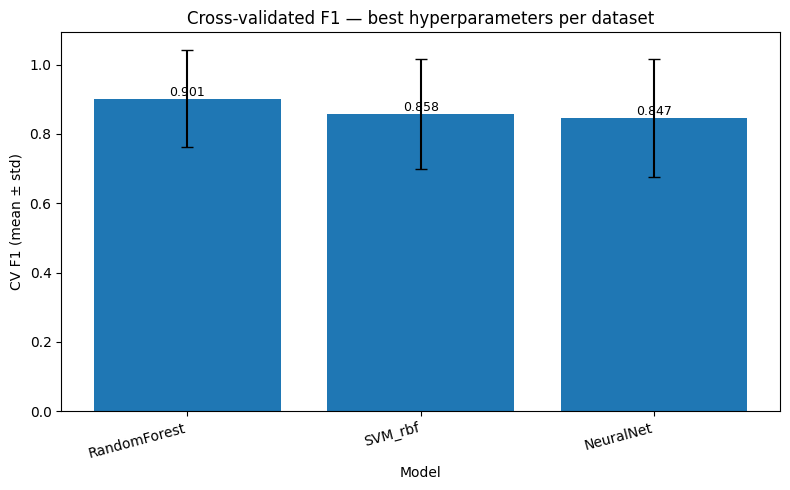

✅ Saved: model_cv_f1_best_bar.png, model_cv_f1_best_bar.pdf


In [3]:
# === Report Plot: CV F1 (best hyperparams per dataset) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

RESULTS_CSV = "../all_model_param_results.csv"   # <- adjust if needed
PRIMARY_METRIC = "CV_F1_mean"                 # main selection metric
OUT_PNG = "model_cv_f1_best_bar.png"
OUT_PDF = "model_cv_f1_best_bar.pdf"

# --- Load results ---
df = pd.read_csv(RESULTS_CSV)

# Basic checks
for col in ["Dataset", "Model", PRIMARY_METRIC]:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# --- Pick best row per (Dataset, Model) by PRIMARY_METRIC, tiebreak CV_Accuracy_mean, then prefer faster scoring ---
def pick_best(group, primary=PRIMARY_METRIC, tiebreak="CV_Accuracy_mean"):
    g = group.copy()
    sort_cols, ascending = [], []
    if primary in g.columns: sort_cols.append(primary); ascending.append(False)
    if tiebreak in g.columns: sort_cols.append(tiebreak); ascending.append(False)
    if "Score_time_mean_s" in g.columns: sort_cols.append("Score_time_mean_s"); ascending.append(True)
    if not sort_cols:  # fallback
        return g.iloc[[0]]
    return g.sort_values(sort_cols, ascending=ascending, na_position="last").iloc[[0]]

best_rows = (
    df.groupby(["Dataset","Model"], group_keys=False)
      .apply(pick_best)
      .reset_index(drop=True)
)

# --- Aggregate across datasets ---
agg = (best_rows
       .groupby("Model")[PRIMARY_METRIC]
       .agg(["mean","std","count"])
       .sort_values("mean", ascending=False)
       .reset_index())

# --- Plot (matplotlib; single plot; no explicit colors or styles) ---
plt.figure(figsize=(8, 5))
bars = plt.bar(agg["Model"], agg["mean"], yerr=agg["std"], capsize=4)
plt.ylabel("CV F1 (mean ± std)")
plt.xlabel("Model")
plt.title("Cross-validated F1 — best hyperparameters per dataset")
plt.xticks(rotation=15, ha="right")

# Annotate bars with mean values
for rect, val in zip(bars, agg["mean"]):
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, h, f"{val:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.savefig(OUT_PDF, bbox_inches="tight")
plt.show()

print(f"✅ Saved: {OUT_PNG}, {OUT_PDF}")

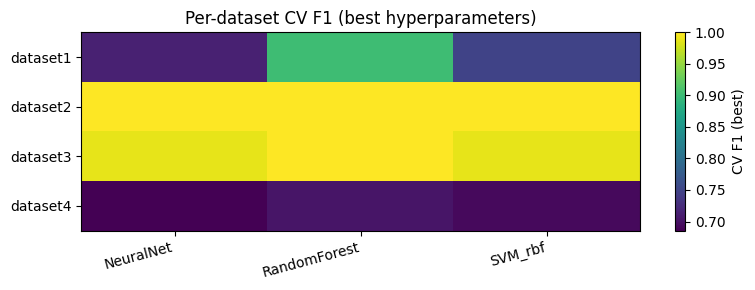

In [4]:
# Per-dataset heatmap (best settings)
pivot = best_rows.pivot(index="Dataset", columns="Model", values="CV_F1_mean").sort_index()
plt.figure(figsize=(8, max(3, 0.4*len(pivot))))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="CV F1 (best)")
plt.xticks(ticks=range(pivot.shape[1]), labels=pivot.columns, rotation=15, ha="right")
plt.yticks(ticks=range(pivot.shape[0]), labels=pivot.index)
plt.title("Per-dataset CV F1 (best hyperparameters)")
plt.tight_layout()
plt.savefig("per_dataset_cv_f1_best_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig("per_dataset_cv_f1_best_heatmap.pdf", bbox_inches="tight")
plt.show()